In [1]:
import torch
from model.torch_hub_models import Hub_Model
from model.CNN import Custom_CNN
from torch.utils.data import DataLoader
from dataset import LoadDataAndLabel
from tqdm import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [2]:
import yaml

def load_config(file_path='config_infer.yaml'):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

# Load configuration
config = load_config()

In [3]:
# Extracting the values from the config
model_configs = config['model']
task = model_configs['task']
model_type = model_configs['type']
length = model_configs['length']
sr = model_configs['sampling_rate']
n_mels = model_configs['n_mels']
n_fft, window_len, step_size = model_configs['window_configs'][sr]
checkpoint = model_configs.get('checkpoint')

In [ ]:
datasets = config['datasets']['paths']
datasets

['dataset/noisy_testset.txt', 'dataset/clean_testset.txt']

In [5]:
if task == "gender":
    n_classes = 2
elif task == "dialect":
    n_classes = 3
else:
    raise ValueError(f"Unsupported task type: {task}. Valid options are 'gender' or 'dialect'.")

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

if model_type == 'CNN':
    # Use the custom CNN-based model
    model = Custom_CNN(
        n_classes=n_classes,
        n_mels=n_mels,
        sampling_rate=sr,
        n_fft=n_fft,
        window=window_len,
        step=step_size
    ).to(device)
else:
    # Use the Model with a pretrained backbone
    try:
        model = Hub_Model(
            n_classes=n_classes,
            n_mels=n_mels,
            sampling_rate=sr,
            n_fft=n_fft,
            window=window_len,
            step=step_size,
            model_type=model_type,
            version=model_configs['versions'][model_type]
        ).to(device)
    except Exception as e:
        raise RuntimeError(f"Failed to load model '{model_type}' from PyTorch Hub: {e}")

In [ ]:
model.load_state_dict(torch.load(checkpoint))
model.eval()

Hub_Model(
  (instancenorm): InstanceNorm1d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
  (torchfb): Sequential(
    (0): PreEmphasis()
    (1): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (bb): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=

In [50]:
def eval(model, loader_eval):
    y_true, y_pred = [], []
    softmax_scores = [] 

    with torch.no_grad():
        for data, target in tqdm(loader_eval):
            probabilities = torch.softmax(model(data.to(device)), dim=1).to('cpu').numpy()
            predicted_class = np.argmax(model(data.to(device)).to('cpu').numpy(), axis=1)
            target = torch.LongTensor(target).to('cpu').numpy()

            y_true.extend(target.tolist())
            y_pred.extend(predicted_class.tolist())
            softmax_scores.extend(probabilities.tolist())

    cm = confusion_matrix(y_true, y_pred)

    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_true), yticklabels=np.unique(y_true))
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 score:", f1)
    print("Support:", support)


------Predicting dataset/noisy_testset.txt...


100%|██████████| 1020/1020 [00:59<00:00, 17.20it/s]


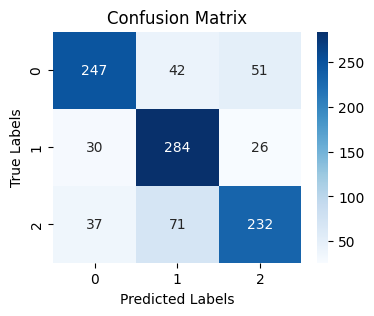

Accuracy: 0.7480392156862745
Precision score: [0.7866242  0.71536524 0.75080906]
Recall score: [0.72647059 0.83529412 0.68235294]
F1 score: [0.75535168 0.77069199 0.71494607] mean 0.7469965824693507
Support: [340 340 340]

------Predicting dataset/clean_testset.txt...


100%|██████████| 1500/1500 [01:35<00:00, 15.74it/s]


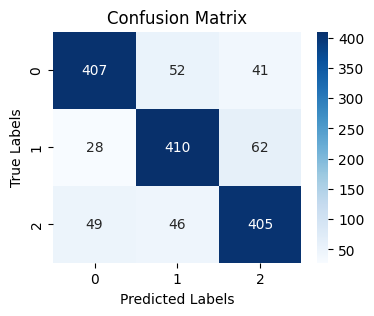

Accuracy: 0.8146666666666667
Precision score: [0.84090909 0.80708661 0.79724409]
Recall score: [0.814 0.82  0.81 ]
F1 score: [0.82723577 0.81349206 0.80357143] mean 0.8147664214737386
Support: [500 500 500]


In [53]:
i = 0
for dataset in datasets:
    print(f"\n------Predicting {dataset}...")
    set = LoadDataAndLabel(
        dataset=dataset,
        audio_length=length,
        sampling_rate=sr,
        window_len=window_len,
        step_size=step_size,
        task_type=task,
    )

    set_loader = DataLoader(set, batch_size=1, num_workers=2, shuffle=False)
    eval(model, set_loader)
    i+=1